In [6]:
import argparse
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.utils.chem import read_sdf, write_sdf, rm_radical, sa, qed, logp
from rdkit import Chem
import random
from coati.generative.molopt import gradient_opt
from coati.generative.coati_purifications import embed_smiles
from functools import partial
from torch.nn.functional import sigmoid
import torch.nn.functional as F
import numpy as np
from coati.generative.coati_purifications import force_decode_valid_batch, embed_smiles, force_decode_valid

from coati.optimize.scoring import ScoringFunction
from coati.optimize.mol_functions import qed_score, substructure_match_score, penalize_macrocycles, heavy_atom_count
from coati.optimize.pso_optimizer import BasePSOptimizer
from coati.optimize.swarm import Swarm
import os
import os.path as osp
import shutil
from glob import glob

arg_parser = argparse.ArgumentParser(description='molecular optimization on the chemical space')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--ecloudgen_ckpt', type=str, default = 'model_ckpts/ecloud_smiles_67.pkl')
arg_parser.add_argument('--noise', type=float, default=0.3)
args = arg_parser.parse_args([])


In [7]:
# model loading
DEVICE = torch.device(args.device)
DEVICE = 'cuda:0'
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.ecloudgen_ckpt,
)

Loading model from model_ckpts/ecloud_smiles_67.pkl
Loading tokenizer mar from model_ckpts/ecloud_smiles_67.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [8]:
class PSO_format_model():
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def seq_to_emb(self, smiles):
        if isinstance(smiles, str):
            smi_emb = embed_smiles(smiles, self.model, self.tokenizer).to(DEVICE)
            return smi_emb
        else:
            emb_list = []
            for smi in smiles:
                smi_emb = embed_smiles(smi, self.model, self.tokenizer).to(DEVICE)
                emb_list.append(smi_emb)
            return torch.stack(emb_list).reshape(-1, 256)

    
    def emb_to_seq(self, embs):

        seq_list = []
        for emb in embs:
            seq = force_decode_valid_batch(emb, self.model, self.tokenizer)
            seq_list.append(seq)
        return seq_list

In [11]:
targets = glob('./data/crossdock_linker_ecloud_32/*')
for target in targets:
    ecloud_file = glob(osp.join(target, '*.npy'))[0]
    sdf_file = sorted(glob(osp.join(target, '*.sdf')), key=len)
    ori_mol_file = sdf_file[0]
    frag_mol_file = sdf_file[1]

    ori_mol = read_sdf(ori_mol_file)[0]
    frag_mol = read_sdf(frag_mol_file)[0]

In [14]:
ecloud_latent = PSO_format_model(encoder, tokenizer, DEVICE)
init_smiles = Chem.MolToSmiles(ori_mol)
init_emb = ecloud_latent.seq_to_emb([init_smiles, init_smiles])

In [29]:
# qed optimization
# substructure constraint 
# molecular weight constraint
# penalize macrocycles

substructure_mol = frag_mol

hac_desirability = [{"x": 0, "y": 0}, {"x": 5, "y": 0.1}, {"x": 15, "y": 0.9}, {"x": 20, "y": 1.0}, {"x": 25, "y": 1.0}, {"x": 30, "y": 0.9,}, {"x": 40, "y": 0.1}, {"x": 45, "y": 0.0}]
substructure_match_score = partial(substructure_match_score, query=substructure_mol) # use partial to define the additional argument (the substructure) 
miss_match_desirability = [{"x": 0, "y": 1}, {"x": 1, "y": 0}] # invert the resulting score to penalize for a match.
match_desirability = [{"x": 0, "y": 0}, {"x": 1, "y": 1}]
scoring_functions = [
    ScoringFunction(substructure_match_score, "miss_match",desirability=match_desirability, is_mol_func=True),
    # ScoringFunction(penalize_macrocycles, "macro", is_mol_func=True)
]
pso_opt = BasePSOptimizer.from_query(
    init_smiles=init_smiles,
    num_part=200,
    num_swarms=3,
    inference_model=ecloud_latent,
    scoring_functions=scoring_functions,
    device=DEVICE)

pso_opt.run(20)

Particle Swarm Optimization...
Step 0, max: 1.000, min: 1.000, mean: 1.000
Step 1, max: 1.000, min: 0.000, mean: 0.100
Step 2, max: 1.000, min: 0.000, mean: 0.100
Step 3, max: 1.000, min: 0.000, mean: 0.100
Step 4, max: 1.000, min: 0.000, mean: 0.100
Step 5, max: 1.000, min: 0.000, mean: 0.100
Step 6, max: 1.000, min: 0.000, mean: 0.100
Step 7, max: 1.000, min: 0.000, mean: 0.100
Step 8, max: 1.000, min: 0.000, mean: 0.100
Step 9, max: 1.000, min: 0.000, mean: 0.100
Step 10, max: 1.000, min: 0.000, mean: 0.100
Step 11, max: 1.000, min: 0.000, mean: 0.100
Step 12, max: 1.000, min: 0.000, mean: 0.100
Step 13, max: 1.000, min: 0.000, mean: 0.100
Step 14, max: 1.000, min: 0.000, mean: 0.100
Step 15, max: 1.000, min: 0.000, mean: 0.100
Step 16, max: 1.000, min: 0.000, mean: 0.100
Step 17, max: 1.000, min: 0.000, mean: 0.100
Step 18, max: 1.000, min: 0.000, mean: 0.100
Step 19, max: 1.000, min: 0.000, mean: 0.100
Particle Swarm Optimization finished.
You can access the best solutions with th

[mso.swarm.Swarm num_part=200 best_fitness=1.0,
 mso.swarm.Swarm num_part=200 best_fitness=1.0,
 mso.swarm.Swarm num_part=200 best_fitness=1.0]

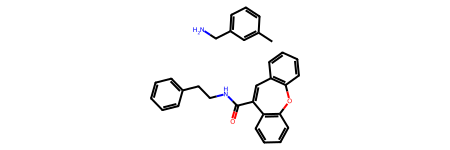

In [ ]:
frag_mol.RemoveAllConformers()
ori_mol.RemoveAllConformers()
frag_mol

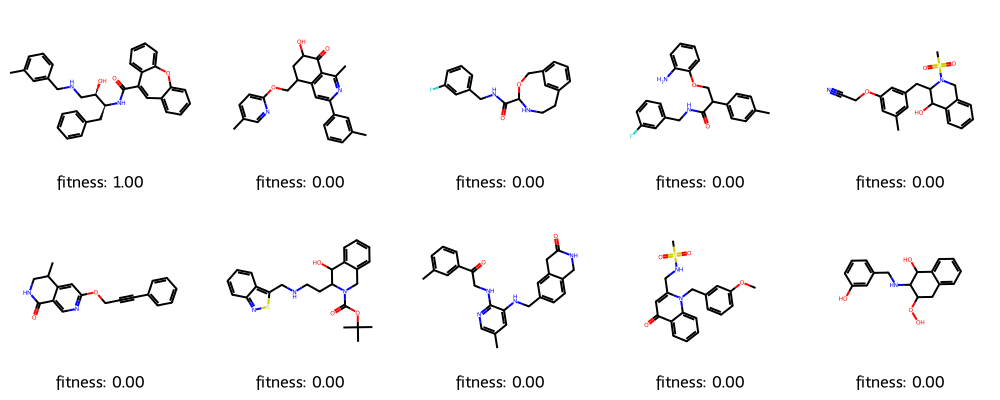

In [30]:
from rdkit.Chem import Draw
opt_smiles = pso_opt.best_solutions['smiles'].to_list()
opt_fitness = pso_opt.best_solutions['fitness'].to_list()
opt_mols = [Chem.MolFromSmiles(smi) for smi in opt_smiles]

Draw.MolsToGridImage(opt_mols, molsPerRow=5, legends=[f"fitness: {f:.2f}" for f in opt_fitness])

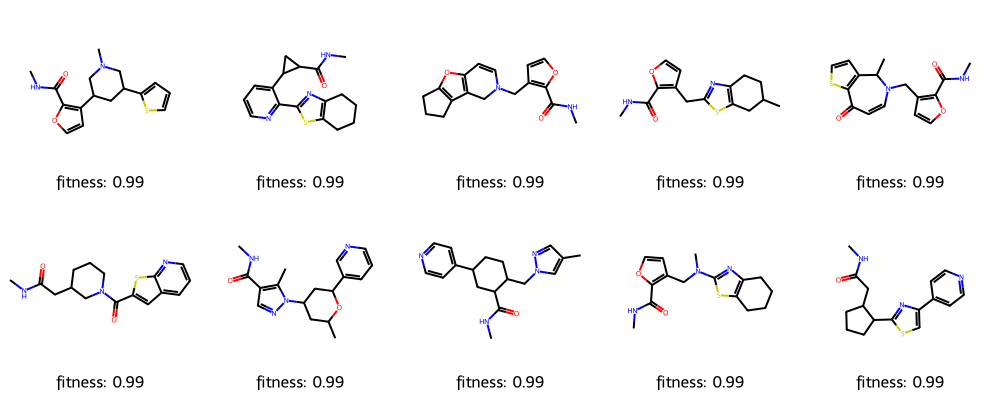

In [31]:
from rdkit.Chem import Draw
opt_smiles = pso_opt.best_solutions['smiles'].to_list()
opt_fitness = pso_opt.best_solutions['fitness'].to_list()
opt_mols = [Chem.MolFromSmiles(smi) for smi in opt_smiles]

Draw.MolsToGridImage(opt_mols, molsPerRow=5, legends=[f"fitness: {f:.2f}" for f in opt_fitness])

In [5]:
from coati.utils.chem import read_pkl

traj_three = read_pkl('./results/conditions_tmp/4bel_bump_dockingqedsa.pkl')[1:]
qed_traj = read_pkl('./results/conditions_tmp/4bel_bump_qed.pkl')[1:]
sa_traj = read_pkl('./results/conditions_tmp/4bel_bump_sa.pkl')[1:]
docking_traj = read_pkl('./results/conditions_tmp/4bel_bump_docking.pkl')[1:]

qeds = [item['qed'] for item in qed_traj]
sas = [item['sa'] for item in sa_traj]
dockings = [item['docking'] for item in docking_traj]


three_qeds = [item['qed'] for item in traj_three]
three_sas = [item['sa'] for item in traj_three]
three_dockings = [item['docking'] for item in traj_three]


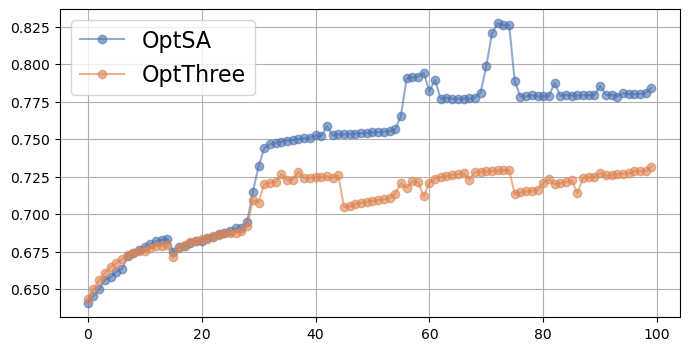

In [129]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

data1 = sas
data2 = three_sas
# 创建一个索引列表，用于x轴的值
x = list(range(len(data1)))
# x = list(range(0, len(data1)*5, 5))
# 使用Seaborn的颜色
colors = sns.color_palette("deep")  # 获取Seaborn的默认深色调色板

# 使用matplotlib绘图
fig, ax = plt.subplots(figsize=(8, 4))

# 使用第一个Seaborn颜色来绘制线条
ax.plot(x, data1, marker='o', linestyle='-', color=colors[0], alpha=0.6, label='OptSA')
ax.plot(x, data2, marker='o', linestyle='-', color=colors[1], alpha=0.6, label='OptThree')
ax.legend(fontsize=16)
# 设置x轴和y轴的刻度间隔
# x_major_locator = MultipleLocator(2)  # x轴每隔2个单位显示一个主刻度标记
# y_major_locator = MultipleLocator(0.05)  # y轴每隔0.1显示一个主刻度标记

# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

ax.grid(True)  # 显示网格

plt.show()

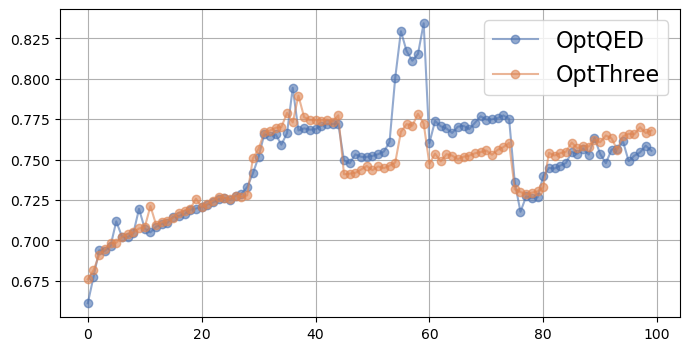

In [135]:
# Sample data, replace 'sas' and 'three_sas' with your actual data arrays
data1 = qeds
data2 = three_qeds
# Creating an index list for the x-axis values
x = list(range(len(data1)))

# Using Seaborn's color palette
colors = sns.color_palette("deep")  # Accessing Seaborn's default deep color palette

# Creating a plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plotting the data using the first two colors from the Seaborn palette
ax.plot(x, data1, marker='o', linestyle='-', color=colors[0], alpha=0.6, label='OptQED')
ax.plot(x, data2, marker='o', linestyle='-', color=colors[1], alpha=0.6, label='OptThree')
ax.legend(fontsize=16)

# Optionally set the locator for major ticks
# ax.xaxis.set_major_locator(MultipleLocator(2))  # Major ticks interval on x-axis
# ax.yaxis.set_major_locator(MultipleLocator(0.05))  # Major ticks interval on y-axis

ax.grid(True)  # Enabling grid

# Display the plot
plt.show()

# Saving the figure in high resolution
fig.savefig("OptQED.png", dpi=300)  # Save as PNG with 300 DPI

In [6]:
from PIL import Image
import io
def save_img(ipy_Image, out_file):
    img_byte_arr = io.BytesIO(ipy_Image.data)
    img_pil = Image.open(img_byte_arr)
    img_pil.save(out_file)
    print('saved at {}'.format(out_file))

In [ ]:
from rdkit.Chem import Draw
import os
import os.path as osp

idx = 30
save_base = './results/conditions_tmp/docking'
os.makedirs(save_base, exist_ok=True)
for idx in range(100):
    mol = [Chem.MolFromSmiles(qed_traj[idx]['smiles'])]
    QED = qed_traj[idx]['qed']
    SA = sa_traj[idx]['sa']
    Docking = docking_traj[idx]['docking']

    legend_qed = f'S: {idx} QED: {QED:.2f}'
    legend_sa = f'S: {idx} SA: {SA:.2f}'
    legend_docking = f'S: {idx} Docking: {Docking:.2f}'

    img = Draw.MolsToGridImage(mol, molsPerRow=1, subImgSize=(200, 200), legends=[legend_qed])
    img

    save_img(img, osp.join(save_base, f'qed_{idx}.png'))

In [ ]:
from rdkit.Chem import Draw

save_base = './results/conditions_tmp/three'
os.makedirs(save_base, exist_ok=True)
for idx in range(100):
    mol = [Chem.MolFromSmiles(traj_three[idx]['smiles'])]
    QED = traj_three[idx]['qed']
    SA = traj_three[idx]['sa']
    Docking = traj_three[idx]['docking']
    legend = f'T: {idx} QED: {QED:.2f}, SA: {SA:.2f}, Docking: {Docking:.2f}'
    legend_qed = f'T: {idx} QED: {QED:.2f}'
    legend_sa = f'T: {idx} SA: {SA:.2f}'
    legend_docking = f'T: {idx} Docking: {Docking:.2f}'

    img = Draw.MolsToGridImage(mol, molsPerRow=1, subImgSize=(200, 200), legends=[legend])
    img

    save_img(img, osp.join(save_base, f'three_{idx}.png'))

In [ ]:
init_smi = init_smiles[0]

In [ ]:
init_mol = [Chem.MolFromSmiles(init_smi)]
init_qed = get_qed(init_emb_vec).detach().cpu().numpy().item()
init_sa = get_sa(init_emb_vec).detach().cpu().numpy().item()
init_docking = get_docking(init_emb_vec).detach().cpu().numpy().item()
legend = f'QED: {init_qed:.2f}, SA: {init_sa:.2f}, Docking: {init_docking:.2f}'
legend_qed = f'QED: {0.66:.2f}'
legend_sa = f'SA: {0.64:.2f}'
legend_docking = f'Docking: {-7.4:.2f}'
img = Draw.MolsToGridImage(init_mol, molsPerRow=1, subImgSize=(200, 200), legends=[legend_docking])
img

C/C(=N\NC(=O)Cc1cccc2ccccc12)c1ccc2c3c(cccc13)CC2,4.0000
OC1(c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)CCCC1,7.0969
Nc1cc/c(=N/S(=O)(=O)c2cc(Cl)sc2Cl)[nH]c1,4.0000
Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(=O)n(CC3CC3)nnc2c1,8.2218
[NH3+][C@@H]1CCCC[C@H]1NS(=O)(=O)c1cncc(Br)c1,4.0000

In [ ]:
smi_list = [
    r"C/C(=N\NC(=O)Cc1cccc2ccccc12)c1ccc2c3c(cccc13)CC2",
    r"OC1(c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)CCCC1",
    r'Nc1cc/c(=N/S(=O)(=O)c2cc(Cl)sc2Cl)[nH]c1',
    r'Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(=O)n(CC3CC3)nnc2c1',
    r'[NH3+][C@@H]1CCCC[C@H]1NS(=O)(=O)c1cncc(Br)c1'
]

subset = []
for smi in smi_list:
    init_smi = Chem.MolToSmiles(Chem.MolFromSmiles(f'{smi}'))
    init_emb_vec = embed_smiles(init_smi, encoder, tokenizer).to(DEVICE)
    logp = get_logp(init_emb_vec)
    pic50 = get_pic50(init_emb_vec)
    hist = {"smiles": init_smi, "embed_smiles": init_emb_vec.cpu().numpy()[0], "pic50":pic50.detach().cpu().numpy()[0], "logp":logp.detach().cpu().numpy()[0]}
    subset.append(hist)

In [ ]:
def write_pkl(subset, path):
    import pickle
    with open(path, 'wb') as f:
        pickle.dump(subset, f)

In [ ]:
write_pkl(subset, './results/conditions_tmp/mk14_init.pkl')

In [ ]:

smi_list = [
    r"C/C(=N\NC(=O)Cc1cccc2ccccc12)c1ccc2c3c(cccc13)CC2",
    r"OC1(c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)CCCC1",
    r'Nc1cc/c(=N/S(=O)(=O)c2cc(Cl)sc2Cl)[nH]c1',
    r'Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(=O)n(CC3CC3)nnc2c1',
    r'[NH3+][C@@H]1CCCC[C@H]1NS(=O)(=O)c1cncc(Br)c1'
]
for i, smi in enumerate(smi_list):
    objective_fcn = lambda v: - get_pic50(v)
    init_smi = Chem.MolToSmiles(Chem.MolFromSmiles(f'{smi}'))

    init_emb_vec = embed_smiles(init_smi, encoder, tokenizer).to(DEVICE)
    traj = gradient_opt(
        init_emb_vec = init_emb_vec,
        objective_fcn = objective_fcn_dict[task],  # the constraints below will be added to this.
        encoder = encoder,
        tokenizer = tokenizer,
        add_bump=True,
        constraint_functions={
            "logp_p": get_logp_penalty,
        },  # enforced to == 0 by lagrange multipliers.
        log_functions={
            "logp": get_logp,
            # "qed": get_qed,
            # "sa": get_sa,
            "pic50": get_pic50,
            # "docking": get_docking,
        },  # These log functions will get appended to the history list-dict returned.
        nsteps=4000,
        save_traj_history=f'./results/conditions_tmp/pic50_{i}.pkl',
        save_every=1,
        project_every=15,
        report=False,
    )

    smiles_list = [i['smiles'] for i in traj]
    mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
    # all_mols.extend(mols_list[-4:])

    # write_sdf(all_mols, f'./results/conditions_tmp/4bel_proj_{task}.sdf')

In [21]:
traj = read_pkl('./results/conditions_tmp/pic50_2.pkl')
logs = [item['logp'] for item in traj]
pic50s = [item['pic50'] for item in traj]
logs_reason = [i for i in logs if i < 5 and i > -2]
ratio = len(logs_reason)/len(logs)
print(ratio)

0.926018495376156


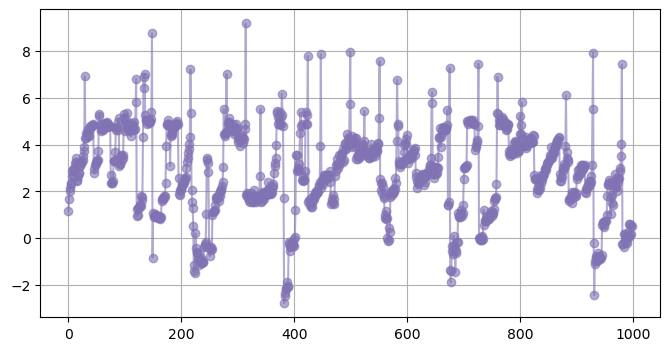

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

data = logs[1:1000]

# 创建一个索引列表，用于x轴的值
x = list(range(len(data)))

# 使用Seaborn的颜色
colors = sns.color_palette("deep")  # 获取Seaborn的默认深色调色板

# 使用matplotlib绘图
fig, ax = plt.subplots(figsize=(8, 4))

# 使用第一个Seaborn颜色来绘制线条
ax.plot(x, data, marker='o', linestyle='-', color=colors[4], alpha=0.6)

# 设置x轴和y轴的刻度间隔
# x_major_locator = MultipleLocator(2)  # x轴每隔2个单位显示一个主刻度标记
# y_major_locator = MultipleLocator(0.05)  # y轴每隔0.1显示一个主刻度标记

# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

ax.grid(True)  # 显示网格
plt.show()

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols_list, molsPerRow=4,subImgSize=(200,200))

In [ ]:
smiles_list = [i['smiles'] for i in traj]
mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
random.shuffle(mols_list)

In [ ]:
pred_qed_list = [i['qed'] for i in traj]
smiles_list = [i['smiles'] for i in traj]
mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
qed_list = [qed(i) for i in mols_list]

In [ ]:
len(pred_qed_list)

In [ ]:
qed_list

In [ ]:
init_mols[0].RemoveAllConformers()

In [ ]:
init_mols[0]

In [ ]:
mols_list[0]

In [ ]:
qed_list

In [ ]:
nsteps = 2000
meta_traj_no_binding = []